In [6]:
#Code Prototype for 2D use on EXCLAIM Project with multiple sensors, code by Joaquin Matticoli

In [7]:
import numpy as np
import filterpy
from filterpy.kalman import KalmanFilter as kf
from filterpy.kalman import predict
from filterpy.kalman import update
from numpy.random import randn
#from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
#import filterpy.stats as stats
import math
from math import sqrt

In [8]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

np.random.seed(24)

def print_gh(predict, update, z1, z2, K):
    predict_template = '{: 7.3f} {: 8.3f}'
    update_template = '{:.3f}\t{:.3f}\t{: 7.3f} {: 7.3f}   {:.3f}'

    print(predict_template.format(predict[0], predict[1]),end='\t')
    print(update_template.format(z1, z2, update[0], update[1], K))

In [9]:
class PayloadSimulation(object):
    def __init__(self, x0=0, angular_velocity2=1,
                 measurement1_var=0.0, measurement2_var = 0.0,
                 process_var=0.0):
        """ x0 : initial orientation
            angular_velocity: (+=counterclockwise, -=clockwise)
            measurement_var: variances in measurement deg^2
            process_var: variance in process (deg/s)^2
        """
        self.x = x0
        self.angular_velocity = angular_velocity2
        self.meas1_std = sqrt(measurement1_var)
        self.meas2_std = sqrt(measurement2_var)
        self.process_std = sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new orientation of the payload in dt seconds."""
        dx = self.angular_velocity + abs(randn()*self.process_std)
        self.x += dx * dt

    def sense_position(self):
        """ Returns measurement of new orientation in degrees."""
        measurement = self.x + abs(randn()*self.meas1_std)
        return measurement
    
    def sense_velocity(self):
        """ Returns measurement of new angular velocity in deg/sec."""
        measurement2 = self.angular_velocity + abs(randn()*self.meas2_std)
        return measurement2

    def move_and_sense(self):
        """ Move payload, and return measurement of new orientation in degrees"""
        self.move()
        return self.sense_position()

In [10]:
printcase = 1 # If set to 1 it will print out the results
plotcase = 1 # If set to 1 it will plot results

#-----------USER INPUT STARTS------------------------------

number_of_variables = 2 #number of variables being measured
number_of_sensors = 2 #number of sensors used
process_var = 25. # variance in the payload's movement, idk what number is good for this??
sensor1_var = 2. # variance in the sensor
sensor2_var = 0.5 # variance in second sensor
x = gaussian(0., 100.)  # payload's initial orientation in deg
angular_velocity = 0.5 # angular velocity in deg/s
spectral_density = 0.2 #Spectral density of the measurement noise
dt = 1. # time step in seconds
n_iter = 75 # Number of measurements that the sensor will take

#-----------USER INPUT ENDS--------------------------------

process_model = gaussian(angular_velocity*dt, process_var) # displacement to add to x

    #NOTE: sensor variance is in velocity as it measures that so be careful when creating code for that as it's different to other codes
    #NOTE: this code will assume that orientation is always increasing/decreasing and not sinusodial because a more complext Kalman filter is needed for those cases
    
# simulate payload and get measurements
payload = PayloadSimulation(
    x0=x.mean, 
    angular_velocity2=process_model.mean, 
    measurement1_var=sensor1_var, 
    measurement2_var=sensor2_var,
    process_var=process_model.var)

# creates list of measurements, NOTE: modify this section if measurements are provided
zs, zs2, ztrue = [], [], []
for _ in range(n_iter):
    zs.append(payload.move_and_sense())
    zs2.append(payload.sense_velocity())
    ztrue.append(payload.x)
finalposition = payload.x

PREDICT					UPDATE
     x      var		  z1	  z2	    x      var      K
  0.500  125.067	8.235	0.724	  8.089   1.961   0.981
  8.844    2.535	14.114	1.517	 11.825   1.075   0.538
 13.261    1.615	16.340	1.650	 14.613   0.847   0.424
 16.320    1.370	18.480	1.836	 17.177   0.766   0.383
 19.064    1.283	22.975	0.840	 20.259   0.734   0.367
 21.914    1.250	29.634	1.248	 24.604   0.721   0.361
 26.531    1.238	29.635	1.445	 27.531   0.716   0.358
 29.429    1.233	34.191	0.545	 30.814   0.715   0.357
 32.404    1.232	35.037	0.501	 33.090   0.714   0.357
 34.362    1.231	42.470	1.234	 37.246   0.714   0.357
 38.976    1.231	45.132	1.693	 41.164   0.714   0.357
 43.238    1.231	53.547	1.977	 46.894   0.714   0.357
 49.530    1.231	53.569	0.915	 50.568   0.714   0.357
 52.695    1.231	56.417	0.705	 53.690   0.714   0.357
 55.419    1.231	66.118	1.229	 59.119   0.714   0.357
 61.258    1.231	66.102	0.533	 62.610   0.714   0.357
 64.337    1.231	75.270	1.703	 68.233   0.714   0.357
 70.589    1.23

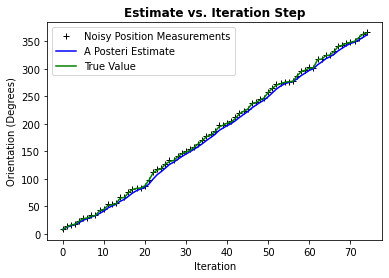

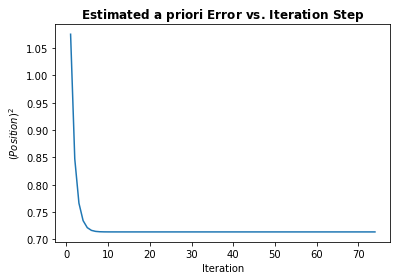

In [11]:
def plotstuff():
    plt.figure()
    plt.plot(zs,'k+',label='Noisy Position Measurements')
    #plt.plot(x1,'r*',label='A Priori Estimate')
    plt.plot(xhat,'b-',label='A Posteri Estimate')
    plt.plot(ztrue,color='g',label='True Value')
    plt.legend()
    plt.title('Estimate vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Orientation (Degrees)')
    
    plt.figure()
    valid_iter = range(1,n_iter) # Pminus not valid at step 0
    plt.plot(valid_iter,Pminus[valid_iter],label='A Posteri Error Estimate')
    plt.title('Estimated $\it{\mathbf{a \ priori}}$ Error vs. Iteration Step', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('$(Position)^2$')
    #plt.setp(plt.gca(),'ylim',[0,.01])
    plt.show()

x1 = np.zeros(n_iter) #Estimate before update
Pminus = np.zeros(n_iter) #Variance after update
xhat = np.zeros(n_iter) #Estimate after update
counter = 0
if printcase == 1:
    print('PREDICT\t\t\t\t\tUPDATE')
    print('     x      var\t\t  z1\t  z2\t    x      var      K')

# perform Kalman filter on measurement(s) z
f = kf(dim_x=number_of_variables, dim_z=number_of_sensors)
f.F = np.array([[1., dt], [0., 1.]]) #correct for calculating position from position and velocity
f.H = np.array([[1., 0.], [0., 1.]]) #this is for first sensor measuring position and second one velocity
f.x = np.array([[x.mean], [angular_velocity*dt]])
f.Q *= np.array([[(dt**3)/3, (dt**2)/2],
                  [(dt**2)/2,  dt      ]]) *spectral_density
f.P = np.diag([x.var,process_var]) #Variance
f.R = np.diag([sensor1_var, sensor2_var])  #Noise in sensors

for i in range(n_iter):    
    f.predict()
    prior = gaussian(f.x_prior[0,0], f.P_prior[0,0])
    f.update(np.array([zs[i], zs2[i]]))
    x = gaussian(f.x[0,0], f.P[0,0])
    if printcase == 1:
        print_gh(prior, x, zs[i], zs2[i], f.K[0,0])
    if plotcase == 1:
        x1[i] = prior.mean
        xhat[i] = x.mean
        Pminus[i] = x.var

if printcase == 1:
    print()
    print('Final estimate:           {:10.3f}'.format(x.mean))
    print('Actual final orientation: {:10.3f}'.format(payload.x))
if plotcase == 1:
    plotstuff()